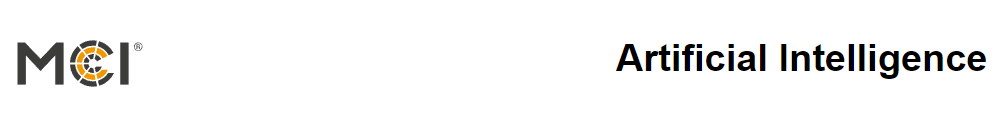

---
# 02 b Data Augmentation for Signals in Biomechanics

### 1.1 The Problem

A counter movement jump (CMJ) is a classic test to evaluate fitness, motion and injury risk factors. State of the art for assessing a patient for compensation movements after an anterior cruciate ligament reconstruction (ACLR) is a a CMJ on force plates. The therapist does the analysis of the force plat data manually e.g. by comparing the left and right foot's ground reaction force over time. This is a time consuming task, so it would be of use if an algorithm can support the process.

Before we can start we need to make the first step by importing all the relevant libraries

In [2]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

### 1.2 Data Aquisition

As we have imported all libraries, we can now have a look on the Data. Therefore, we define the paths to our dataset.

In [4]:
# Define directory paths
directory_path_injured = '../Data/ACL_Rehab/CMJ_Injured'
directory_path_uninjured = '../Data/ACL_Rehab/CMJ_Uninjured'
paths = {directory_path_injured, directory_path_uninjured}

In a next step we need to load the data to create our raw dataset

In [5]:
all_combined_filtered_elements = []
# iterate through all patients in both healthy and unhealthy
for pathiteration in paths:
    used_directory_path = pathiteration
    combined_filtered_elements = []
    # detect whether the directory is empty or not
    if os.path.exists(used_directory_path):
        files_and_directories = os.listdir(used_directory_path)
        if not files_and_directories:
            print("The Directory is empty!")
        else:
          # if directory is not empty, it iterates through the data and saves all the names of the files of the uninjured patients in the list 'combined_filtered_elements' if the word '3d' is in it.
          #For the injured it goes through the folder, and hence in the folder of the injured is only the patient data it is not further filtered for names. Therefore the
          # the names are just stored in the list 'combined_filtered_elements' like the uninjured patients.
            for item in files_and_directories:
                new_directory_path_uninjured = os.path.join(used_directory_path, item)
                if os.path.exists(new_directory_path_uninjured):
                    under_files_and_directories = os.listdir(new_directory_path_uninjured)
                    filtered_elements = [element for element in under_files_and_directories if "3d" in element.lower()]
                    if not filtered_elements:
                        filtered_elements = under_files_and_directories
                    for element in filtered_elements:
                        combined_filtered_elements.append(os.path.join(new_directory_path_uninjured, element))
    else:
        print("The specified directory does not exist.")

    all_combined_filtered_elements.extend(combined_filtered_elements)

print("\nOverall length combined list of filtered elements:")
print(len(all_combined_filtered_elements))


Overall length combined list of filtered elements:
43


We have only 43 samples. But in the current state we only have a list of them. Now we need to extract the data from the respective files. The goal is to extract only essential information.

As the lecture should be as close to reality, the data aquisition was done in two different way. The data structure therefore differed between the "healthy" and "unhealthy" group, so the is the need to process them separately to achieve a uniform final dataset. Additionally, we trimmed the data to extract relevant segments, ensuring each jump had the same length and focused on the same window.

In [8]:
newdata = []

# Function to trim data based on Z force entering a specified range for a given duration
def trim_data_based_on_z_force(data, z_force_key, lower_bound=-10, upper_bound=10, duration=0.5):
    time = data['time']
    z_force = data[z_force_key]
    framerate = 100  # Assuming the framerate is 100 Hz
    samples_needed = int(framerate * duration)

    # Find the first index where z_force is within the range [lower_bound, upper_bound] for the specified duration
    for i in range(len(z_force) - samples_needed):
        if all(lower_bound <= z_force[j] <= upper_bound for j in range(i, i + samples_needed)):
            trigger_point = i
            start_index = max(0, trigger_point - int(0.8*framerate))  # Start 0.8 seconds before the trigger point
            end_index = min(len(time), trigger_point + int(1.8 * framerate))  # End 1.8 seconds after the trigger point
            break
    else:
        return None  # Return None if no suitable segment is found


    print("Start: "+str(start_index))
    print("End: "+str(end_index))
    print("Length: " +str(end_index-start_index))

    # Trim the data
    trimmed_time = time[start_index:end_index]
    trimmed_data = {
        'time': trimmed_time,
        'force_plate_1_x': data['force_plate_1_x'][start_index:end_index],
        'force_plate_1_y': data['force_plate_1_y'][start_index:end_index],
        'force_plate_1_z': data['force_plate_1_z'][start_index:end_index],
        'force_plate_2_x': data['force_plate_2_x'][start_index:end_index],
        'force_plate_2_y': data['force_plate_2_y'][start_index:end_index],
        'force_plate_2_z': data['force_plate_2_z'][start_index:end_index]
    }

    return trimmed_data



# Load and process the data
for index, item in enumerate(all_combined_filtered_elements):
    with open(item, 'r') as file:
        data = json.load(file)

        # Unhealthy data
        if "startTime" in data:
            framerate = data['frameRate']
            if framerate == 100:
                start = data['startTime']
                end = data['endTime']
                duration = end - start
                n_frames = int(framerate * duration)
                frame_numbers = np.arange(1, n_frames + 2)
                time = frame_numbers / framerate

                force_plate_1_x = [frame['force'][0]['data']['force'][0] for frame in data['frames']]
                force_plate_1_y = [frame['force'][0]['data']['force'][1] for frame in data['frames']]
                force_plate_1_z = [frame['force'][0]['data']['force'][2] for frame in data['frames']]
                force_plate_2_x = [frame['force'][1]['data']['force'][0] for frame in data['frames']]
                force_plate_2_y = [frame['force'][1]['data']['force'][1] for frame in data['frames']]
                force_plate_2_z = [frame['force'][1]['data']['force'][2] for frame in data['frames']]

                if len(time) != len(force_plate_1_x):
                    force_plate_1_x = [data['frames'][i]['force'][0]['data']['force'][0] for i in range(len(time))]
                    force_plate_1_y = [data['frames'][i]['force'][0]['data']['force'][1] for i in range(len(time))]
                    force_plate_1_z = [data['frames'][i]['force'][0]['data']['force'][2] for i in range(len(time))]
                    force_plate_2_x = [data['frames'][i]['force'][1]['data']['force'][0] for i in range(len(time))]
                    force_plate_2_y = [data['frames'][i]['force'][1]['data']['force'][1] for i in range(len(time))]
                    force_plate_2_z = [data['frames'][i]['force'][1]['data']['force'][2] for i in range(len(time))]

                raw_data = {
                    'time': time,
                    'force_plate_1_x': force_plate_1_x,
                    'force_plate_1_y': force_plate_1_y,
                    'force_plate_1_z': force_plate_1_z,
                    'force_plate_2_x': force_plate_2_x,
                    'force_plate_2_y': force_plate_2_y,
                    'force_plate_2_z': force_plate_2_z
                }

                trimmed_data = trim_data_based_on_z_force(raw_data, 'force_plate_1_z')
                if trimmed_data:
                    trimmed_data['status'] = 'injured'
                    newdata.append(trimmed_data)

        # Healthy data
        if "Name" in data:
            framerate = data['Timebase']['Frequency']
            if framerate == 100:
                start = data['ForcePlates'][0]['Parts'][0]['Range']['Start']
                end = data['ForcePlates'][0]['Parts'][0]['Range']['End']
                duration = (end - start) / 100
                n_frames = int(framerate * duration)
                frame_numbers = np.arange(1, n_frames + 2)
                time = frame_numbers / framerate

                force_plate_1_x = [frame[0] for frame in data['ForcePlates'][0]['Parts'][0]['Values']]
                force_plate_1_y = [frame[1] for frame in data['ForcePlates'][0]['Parts'][0]['Values']]
                force_plate_1_z = [frame[2] for frame in data['ForcePlates'][0]['Parts'][0]['Values']]
                force_plate_2_x = [frame[0] for frame in data['ForcePlates'][1]['Parts'][0]['Values']]
                force_plate_2_y = [frame[1] for frame in data['ForcePlates'][1]['Parts'][0]['Values']]
                force_plate_2_z = [frame[2] for frame in data['ForcePlates'][1]['Parts'][0]['Values']]

                if len(time) != len(force_plate_1_x):
                    frame_numbers = np.arange(1, int(n_frames / 2) + 2)
                    time = frame_numbers / framerate

                # Reduce time array and force plate data to every 10th element
                reduced_time = time[::10] / 10
                reduced_force_plate_1_x = force_plate_1_x[::10]
                reduced_force_plate_1_y = force_plate_1_y[::10]
                reduced_force_plate_1_z = force_plate_1_z[::10]
                reduced_force_plate_2_x = force_plate_2_x[::10]
                reduced_force_plate_2_y = force_plate_2_y[::10]
                reduced_force_plate_2_z = force_plate_2_z[::10]

                raw_data = {
                    'time': reduced_time,
                    'force_plate_1_x': reduced_force_plate_1_x,
                    'force_plate_1_y': reduced_force_plate_1_y,
                    'force_plate_1_z': reduced_force_plate_1_z,
                    'force_plate_2_x': reduced_force_plate_2_x,
                    'force_plate_2_y': reduced_force_plate_2_y,
                    'force_plate_2_z': reduced_force_plate_2_z
                }

                trimmed_data = trim_data_based_on_z_force(raw_data, 'force_plate_1_z')
                if trimmed_data:
                    trimmed_data['status'] = 'uninjured'
                    newdata.append(trimmed_data)

Start: 117
End: 377
Length: 260
Start: 73
End: 333
Length: 260
Start: 122
End: 382
Length: 260
Start: 313
End: 573
Length: 260
Start: 314
End: 574
Length: 260
Start: 69
End: 329
Length: 260
Start: 142
End: 402
Length: 260
Start: 33
End: 293
Length: 260
Start: 72
End: 332
Length: 260
Start: 15
End: 275
Length: 260
Start: 173
End: 433
Length: 260
Start: 174
End: 434
Length: 260
Start: 87
End: 347
Length: 260
Start: 45
End: 305
Length: 260
Start: 38
End: 298
Length: 260
Start: 84
End: 344
Length: 260
Start: 46
End: 306
Length: 260
Start: 104
End: 364
Length: 260
Start: 343
End: 603
Length: 260
Start: 202
End: 462
Length: 260
Start: 204
End: 464
Length: 260
Start: 200
End: 460
Length: 260


The raw data that was extracted includes the time array and the force arrays in each direction (x, y, z) for both force plates, representing the left and right foot.

To gain insights into these processed datasets, the data should be plotted the force exerted on each plate over time.

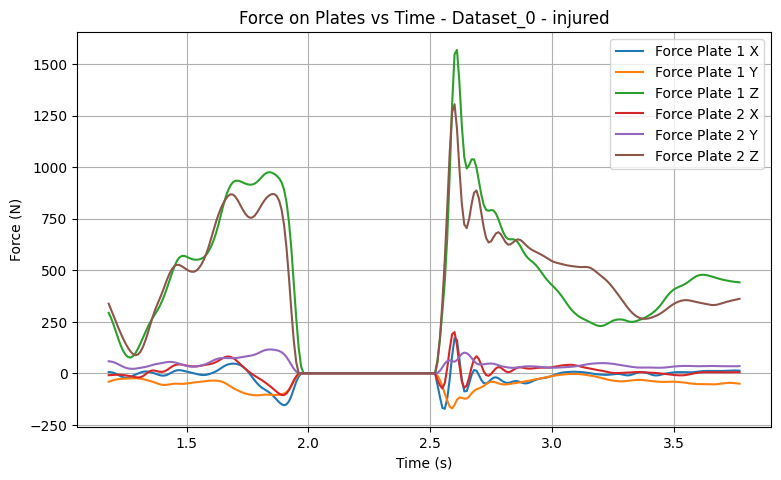

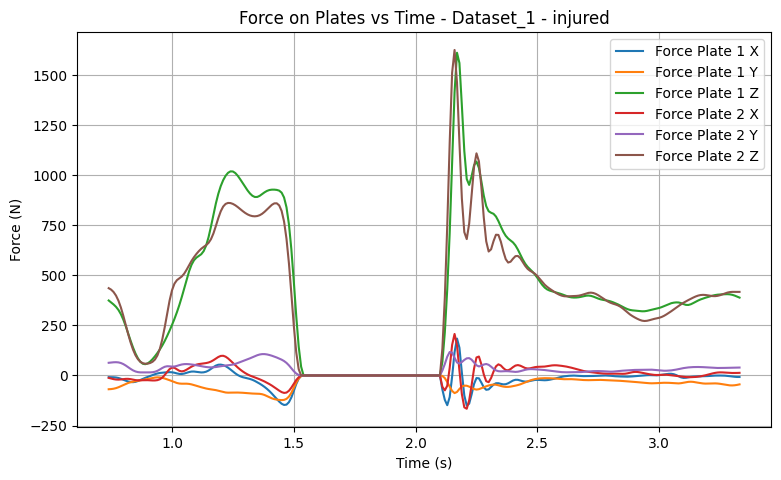

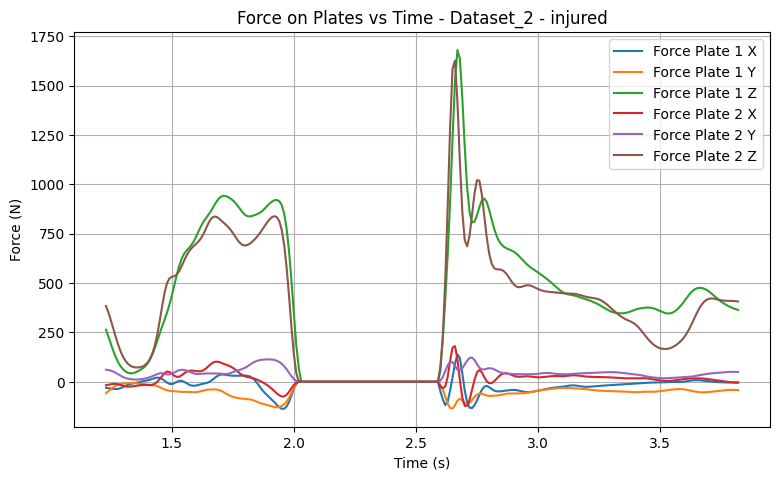

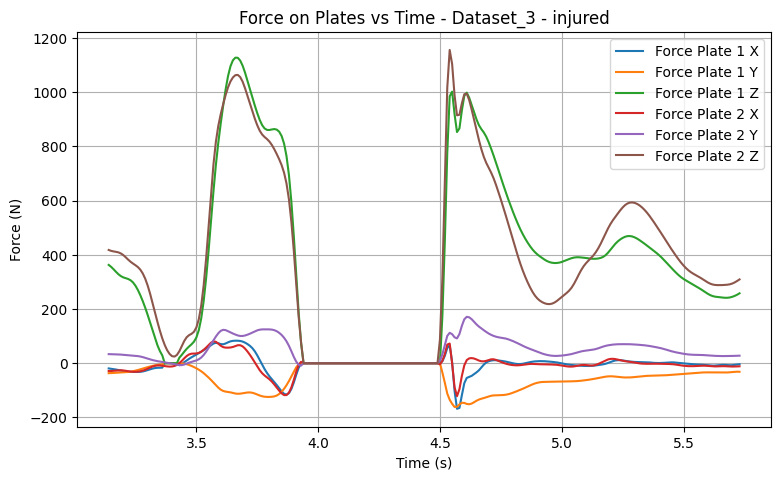

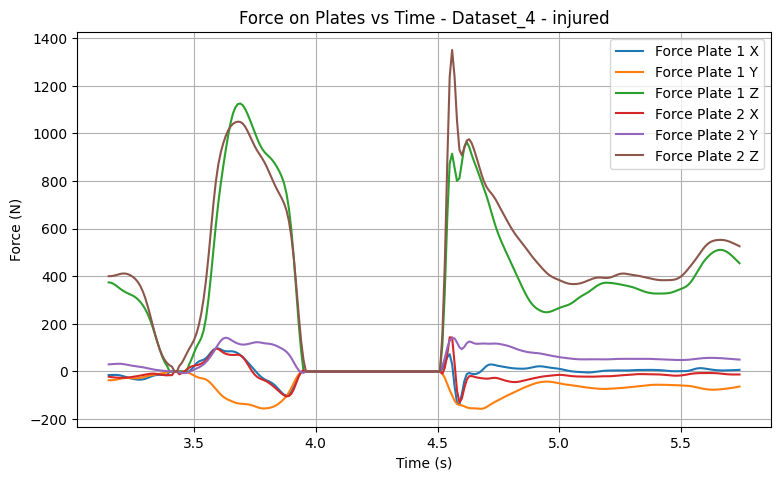

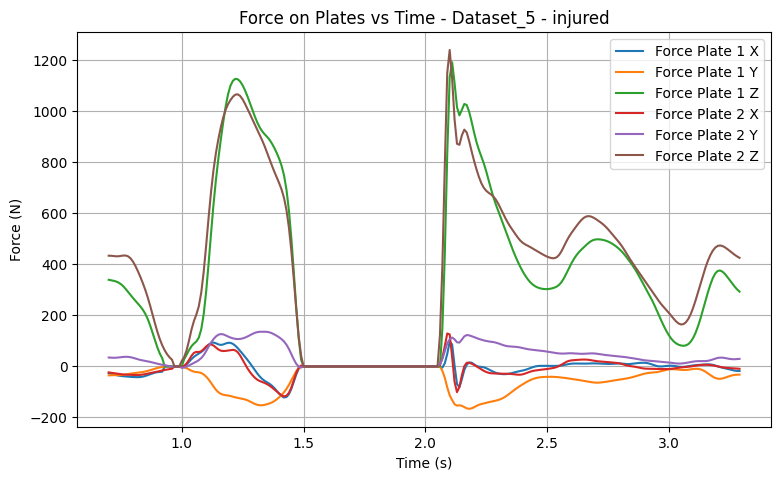

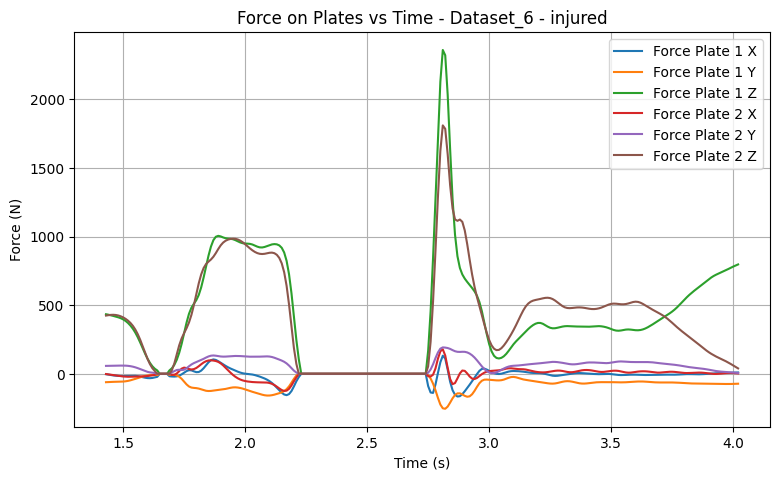

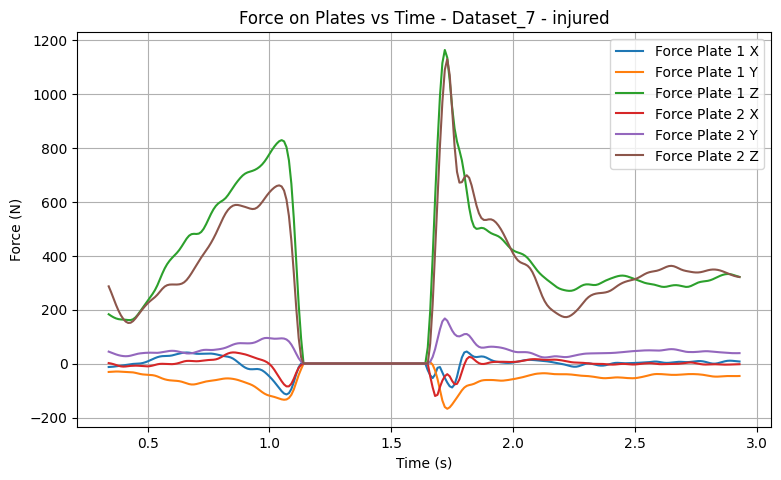

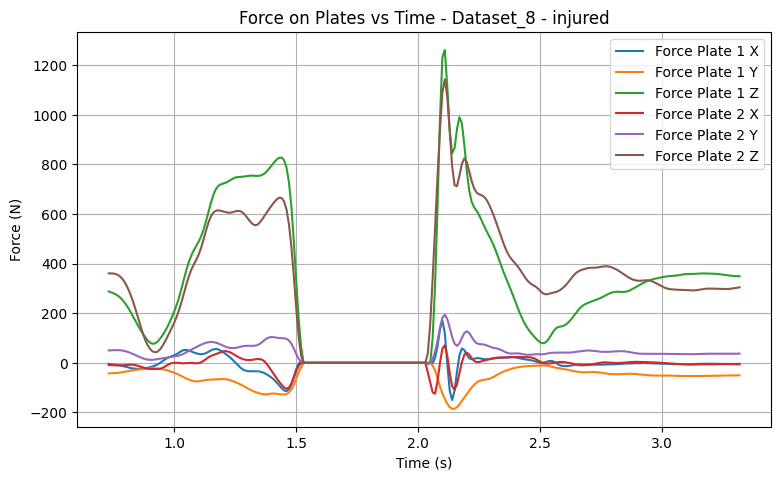

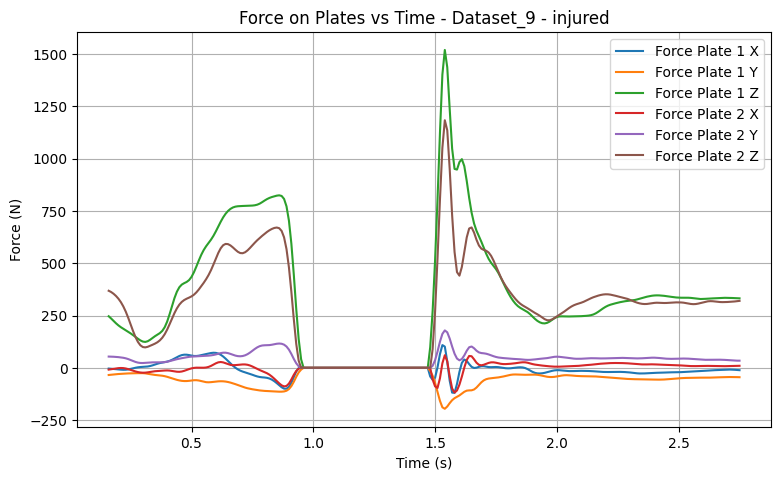

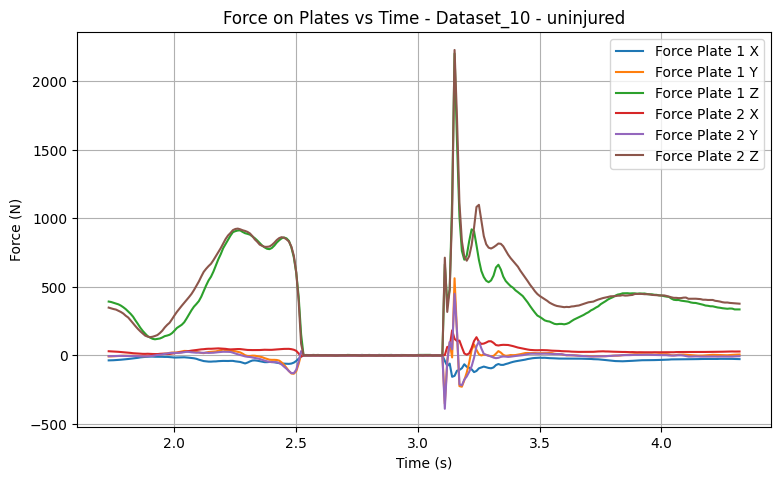

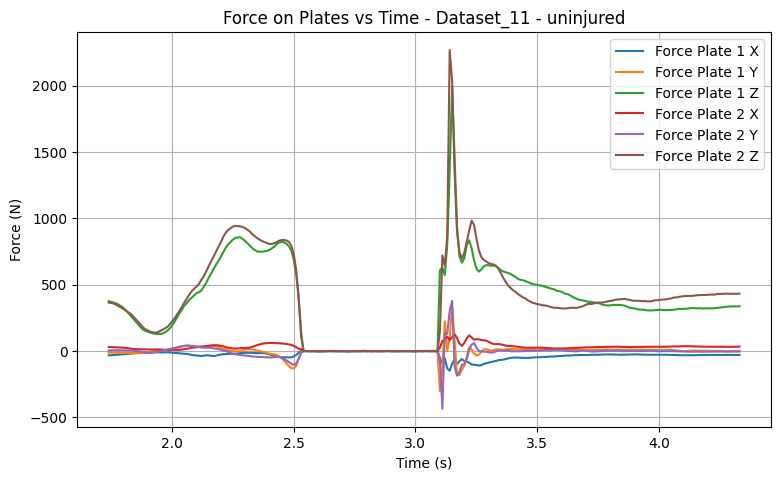

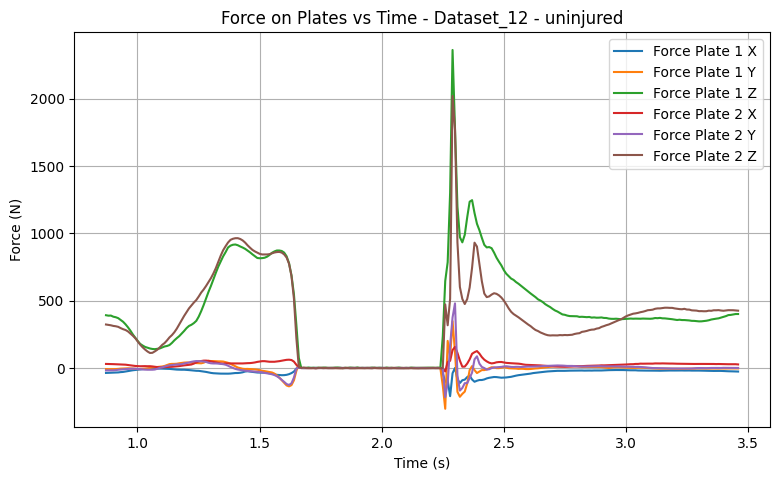

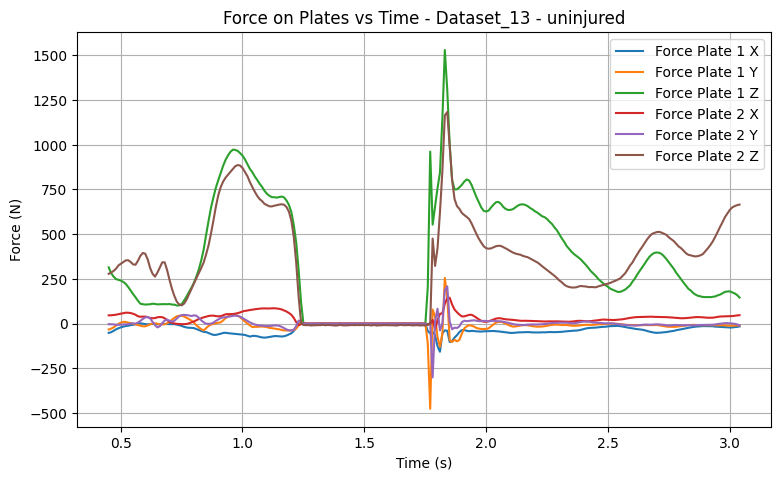

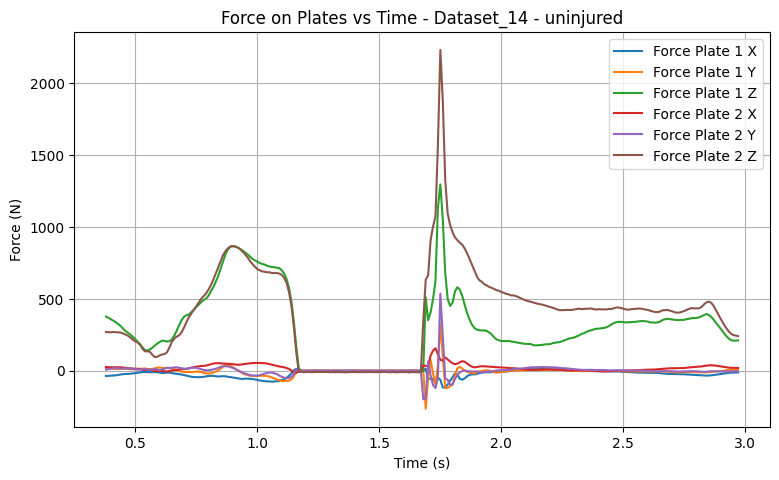

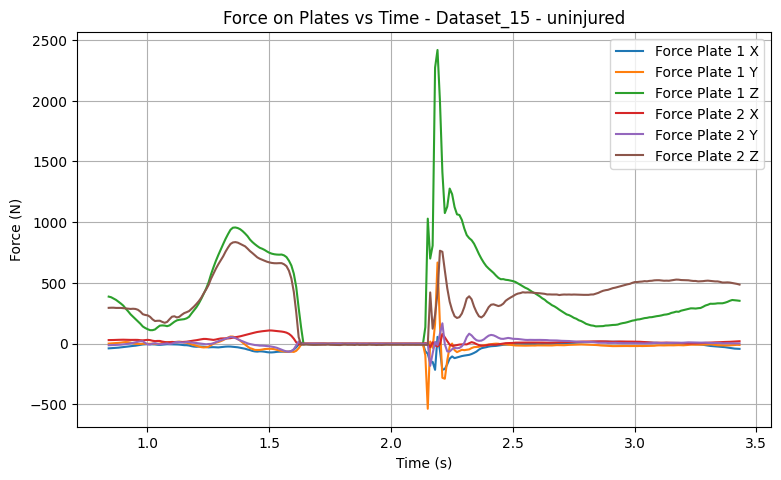

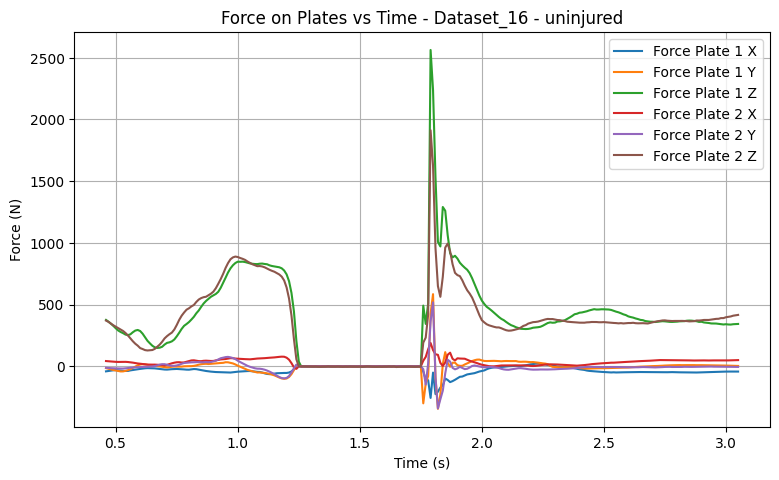

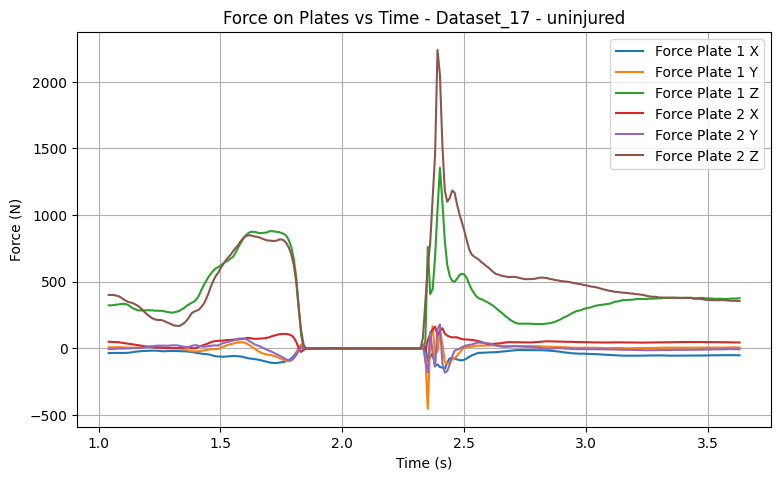

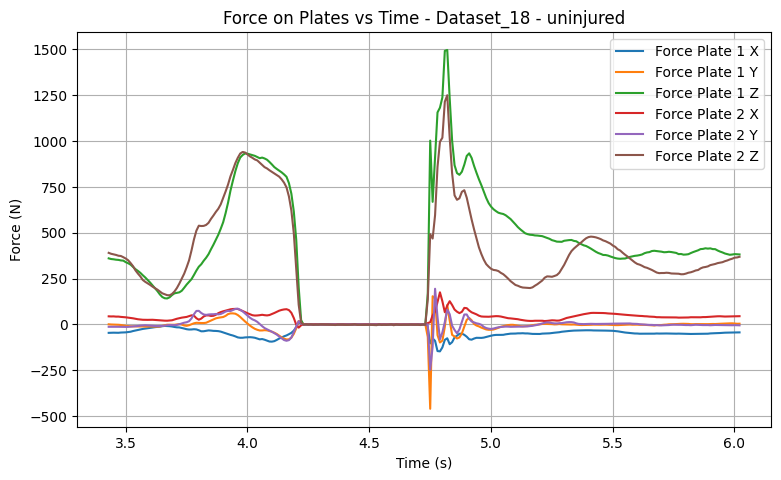

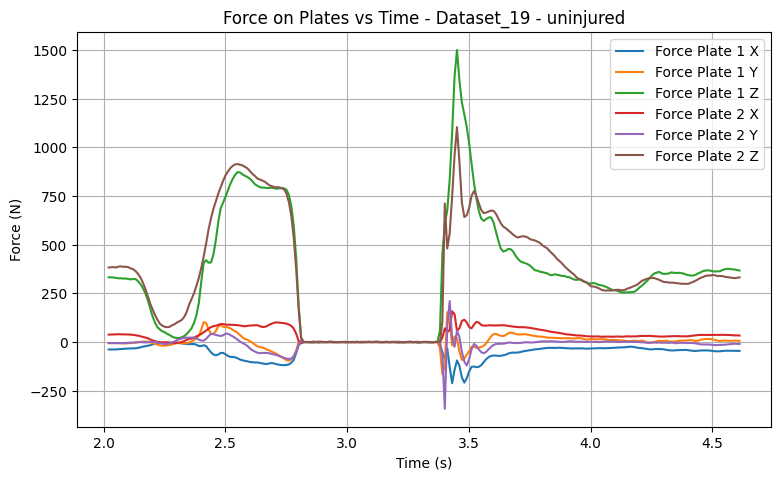

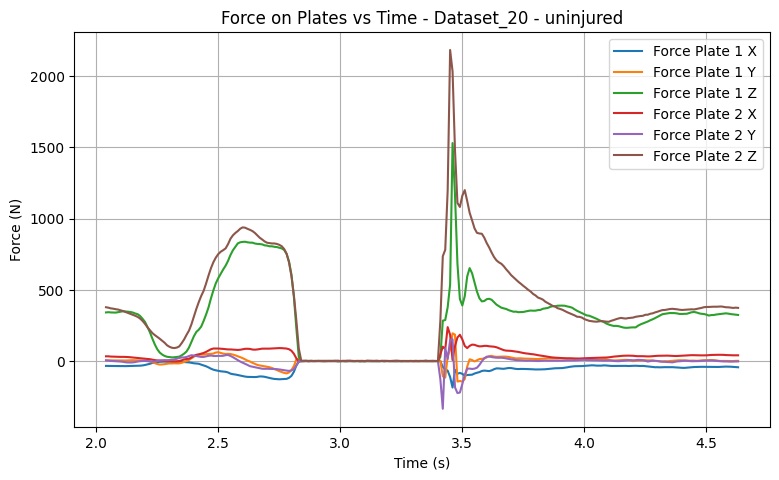

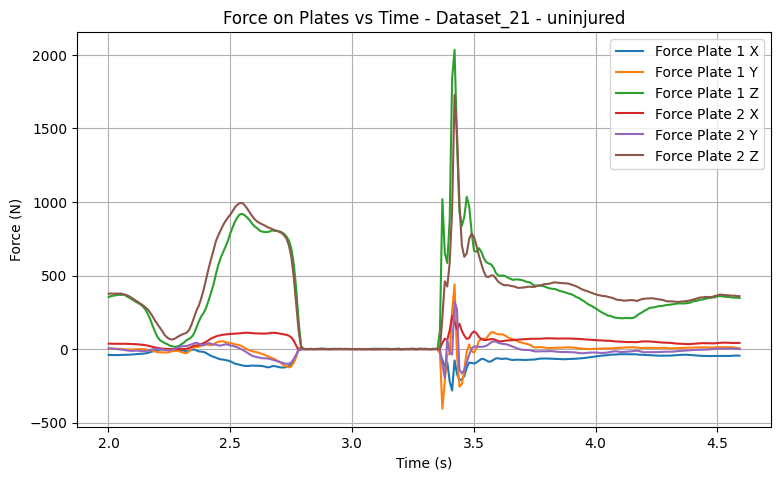

In [9]:
for i, data in enumerate(newdata):
    # Create a new figure for each dataset
    plt.figure(figsize=(15, 9))
    plt.subplot(2, 2, 1)
    plt.plot(data['time'], data['force_plate_1_x'], label='Force Plate 1 X')
    plt.plot(data['time'], data['force_plate_1_y'], label='Force Plate 1 Y')
    plt.plot(data['time'], data['force_plate_1_z'], label='Force Plate 1 Z')
    plt.plot(data['time'], data['force_plate_2_x'], label='Force Plate 2 X')
    plt.plot(data['time'], data['force_plate_2_y'], label='Force Plate 2 Y')
    plt.plot(data['time'], data['force_plate_2_z'], label='Force Plate 2 Z')

    plt.title(f"Force on Plates vs Time - Dataset_{i} - {data['status']}")
    plt.xlabel('Time (s)')
    plt.ylabel('Force (N)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Optionally save the figure
    # plt.savefig(f'force_plot_dataset_{i+1}.png')

    # Display the plot
    plt.show()

These plots clearly represent the force dynamics during jumps, aiding in a qualitative understanding of the data. At the same time it became clear, that from 43 sample only 22 made it into the raw dataset. This is also something that is quite common in industry. You expect a dataset of a specific size, but you loose some data when you create a dataset from it.

### 1.3. Augmentation

As we only have 22 sampels we need to increase the size of the dataset. At first we have a look on how a sample is comprised

In [10]:
Dataframe = pd.DataFrame(newdata)
Dataframe.head()

,time,force_plate_1_x,force_plate_1_y,force_plate_1_z,force_plate_2_x,force_plate_2_y,force_plate_2_z,status
0,"[1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25...","[5.788761, 4.977563, 2.094099, -2.706005, -8.8...","[-41.146301, -37.066334, -33.363045, -30.44234...","[293.031097, 266.967896, 235.336472, 200.33636...","[-9.472301, -8.999226, -8.107635, -7.299421, -...","[58.068562, 56.480793, 53.548485, 49.109707, 4...","[337.42453, 308.550751, 278.654968, 248.792831...",injured
1,"[0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81...","[-8.46418, -8.677547, -8.977587, -10.11197, -1...","[-68.798889, -67.961571, -66.163757, -63.23434...","[374.46344, 364.900024, 354.706757, 342.798492...","[-12.112279, -15.47556, -18.305021, -20.17016,...","[63.295513, 64.676659, 65.824051, 66.242973, 6...","[435.946594, 428.695648, 416.837158, 398.97842...",injured
2,"[1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3...","[-30.230509, -32.100086, -34.113121, -36.01263...","[-57.484642, -47.881535, -37.671539, -28.17795...","[263.728668, 227.513519, 190.769623, 155.81629...","[-17.176435, -14.890965, -12.27727, -10.507695...","[61.006851, 59.384872, 56.232109, 51.34557, 44...","[383.686798, 350.627319, 311.398132, 268.90701...",injured
3,"[3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21...","[-19.28792, -20.578707, -21.857477, -23.400616...","[-36.780453, -36.447151, -35.869362, -35.18265...","[362.6716, 355.517426, 346.667023, 337.097198,...","[-28.830914, -28.710476, -27.952793, -26.93392...","[33.467033, 33.047138, 32.772926, 32.563839, 3...","[417.815094, 414.524628, 412.433563, 410.92892...",injured
4,"[3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22...","[-14.974478, -14.599116, -14.189309, -14.30083...","[-36.723907, -36.788876, -36.029766, -34.42518...","[374.111084, 372.580719, 367.849274, 360.97540...","[-21.847158, -23.613632, -24.822941, -25.61119...","[29.855463, 30.481478, 31.357182, 32.136597, 3...","[400.215118, 400.490845, 402.060211, 404.70443...",injured


We can see that each sample has several vectors in them. The last coloumn is the status (heathly, unhealthy). As the initial idea was to predict whether someone is healthy or not in respect to his/her ACL, the status would be the potantial output of a classification algorithm. Well, then let's check the distribution.

<Axes: xlabel='status'>

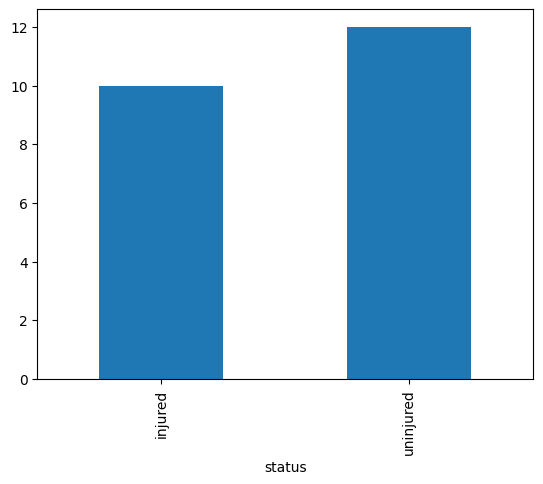

In [11]:
Dataframe.groupby('status').size().plot(kind='bar')

We can definetly see the the dataset is slightly in favour of the healthy patients. The imbalance is not that strong though. If we think of ways to increase the number of samples synthetically, we need to find reasonable augmentation methods.

#### 1.3.1. Augmentation with flipping

Augmentation with flipping is a reasonable option. In this specific case it is possible to do so. By flipping the forces of the left and right force plate we need to be careful. The forces should be flipped along the saggital plane.
To better understand what is happening, we plot the forces of the two plates side by side.

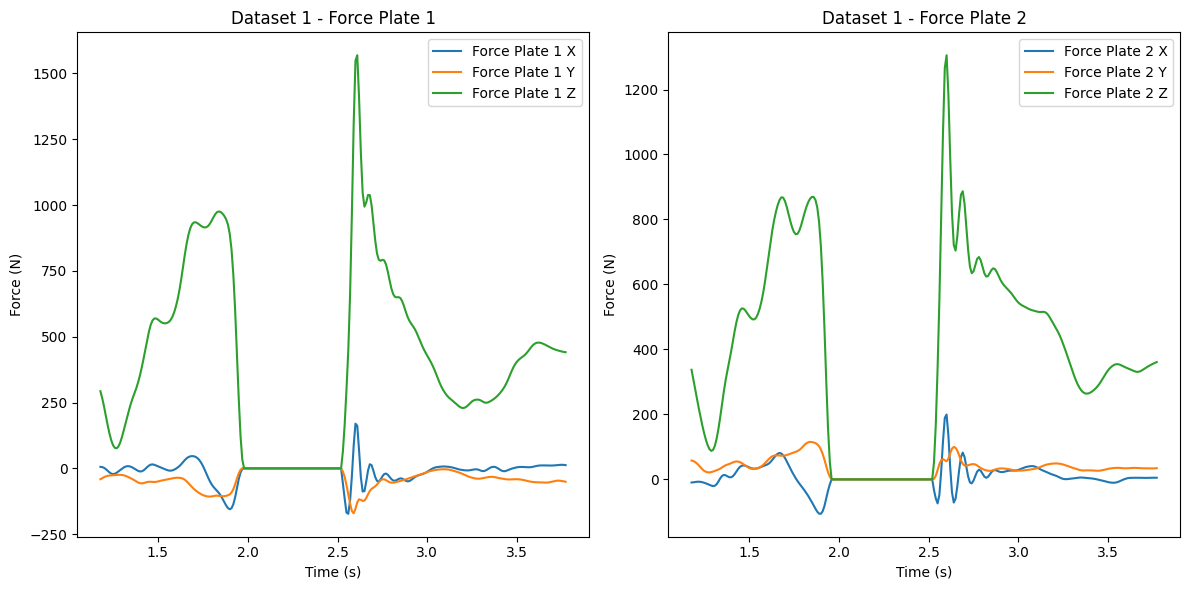

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(newdata[0]['time'], newdata[0]['force_plate_1_x'], label='Force Plate 1 X')
plt.plot(newdata[0]['time'], newdata[0]['force_plate_1_y'], label='Force Plate 1 Y')
plt.plot(newdata[0]['time'], newdata[0]['force_plate_1_z'], label='Force Plate 1 Z')
plt.title("Dataset 1 - Force Plate 1")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(newdata[0]['time'], newdata[0]['force_plate_2_x'], label='Force Plate 2 X')
plt.plot(newdata[0]['time'], newdata[0]['force_plate_2_y'], label='Force Plate 2 Y')
plt.plot(newdata[0]['time'], newdata[0]['force_plate_2_z'], label='Force Plate 2 Z')
plt.title("Dataset 1 - Force Plate 2")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.tight_layout()
plt.show()


#### TASK: Flip the y-forces along the saggital plane.

In [13]:
# your code goes here

 Be aware, that you should be able to complete the task on your own.

If you need support, here is the solution to the TASK.
At first we need to check the Dataframes datatypes.

In [14]:
print('The datatype of the Dataframe is ' + str(type(Dataframe)))
print('The datatype of a column in the Dataframe is ' + str(type(Dataframe['force_plate_2_y'])))
print('The datatype of a cell in the column of the Dataframe is ' + str(type(Dataframe['force_plate_2_y'][0])))

The datatype of the Dataframe is <class 'pandas.DataFrame'>
The datatype of a column in the Dataframe is <class 'pandas.Series'>
The datatype of a cell in the column of the Dataframe is <class 'list'>


We can see the the datatype of a cell in a column of the Dataframe is of the list class. Lists are not easy to handle due to their datastructure. Also mathematical processing is not easy with them. We want to change the datatype to a numpy array for easier processing. Therefore we create a function called *convert_dataframe_to_numpy()*

In [15]:
def convert_dataframe_to_numpy(df):
  """Converts all entries of a Pandas DataFrame to NumPy arrays.

  Args:
    df: The Pandas DataFrame to convert.

  Returns:
    A new DataFrame with all entries converted to NumPy arrays.
  """

  new_df = df.copy()
  for column in df.columns:
    if df[column].dtype == object:  # Only convert columns with object type (likely lists or dicts)
        new_df[column] = df[column].apply(lambda x: np.array(x) if isinstance(x, list) else x)

  return new_df

Dataframe_numpy = convert_dataframe_to_numpy(Dataframe)

Now we can check whether the conversion worked.

In [16]:
print('The datatype of the Dataframe is ' + str(type(Dataframe_numpy)))
print('The datatype of a column in the Dataframe is ' + str(type(Dataframe_numpy['force_plate_2_y'])))
print('The datatype of a cell in the column of the Dataframe is ' + str(type(Dataframe_numpy['force_plate_2_y'][0])))

The datatype of the Dataframe is <class 'pandas.DataFrame'>
The datatype of a column in the Dataframe is <class 'pandas.Series'>
The datatype of a cell in the column of the Dataframe is <class 'numpy.ndarray'>


We can now see the the datatype of a cell in a column of the Dataframe is of the numpy.ndarray class. Therefore, it should be possible now to multiply scalars with the numpy arrays in place. To make it easy, we make a function called *exchange_and_negate_y_forces()*

In [91]:
def exchange_and_negate_y_forces(df):
  """
  Exchanges the 'force_plate_1_y' and 'force_plate_2_y' series in a DataFrame
  and multiplies them by -1.

  Args:
    df: The DataFrame containing the series to exchange and negate.

  Returns:
    A new DataFrame with the exchanged and negated series.
  """


  new_df = df.copy()
  for row in range(df.shape[0]):   
    new_df.at[row,'force_plate_1_y'] = (-1)*df.loc[row,'force_plate_2_y']
    new_df.at[row,'force_plate_2_y'] = (-1)*df.loc[row,'force_plate_1_y']

  return new_df


To make things understandable here is the original dataset (called Dataframe_numpy):

In [92]:
Dataframe_numpy.head()

,time,force_plate_1_x,force_plate_1_y,force_plate_1_z,force_plate_2_x,force_plate_2_y,force_plate_2_z,status
0,"[1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25...","[5.788761, 4.977563, 2.094099, -2.706005, -8.8...","[-41.146301, -37.066334, -33.363045, -30.44234...","[293.031097, 266.967896, 235.336472, 200.33636...","[-9.472301, -8.999226, -8.107635, -7.299421, -...","[58.068562, 56.480793, 53.548485, 49.109707, 4...","[337.42453, 308.550751, 278.654968, 248.792831...",injured
1,"[0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81...","[-8.46418, -8.677547, -8.977587, -10.11197, -1...","[-68.798889, -67.961571, -66.163757, -63.23434...","[374.46344, 364.900024, 354.706757, 342.798492...","[-12.112279, -15.47556, -18.305021, -20.17016,...","[63.295513, 64.676659, 65.824051, 66.242973, 6...","[435.946594, 428.695648, 416.837158, 398.97842...",injured
2,"[1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3...","[-30.230509, -32.100086, -34.113121, -36.01263...","[-57.484642, -47.881535, -37.671539, -28.17795...","[263.728668, 227.513519, 190.769623, 155.81629...","[-17.176435, -14.890965, -12.27727, -10.507695...","[61.006851, 59.384872, 56.232109, 51.34557, 44...","[383.686798, 350.627319, 311.398132, 268.90701...",injured
3,"[3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21...","[-19.28792, -20.578707, -21.857477, -23.400616...","[-36.780453, -36.447151, -35.869362, -35.18265...","[362.6716, 355.517426, 346.667023, 337.097198,...","[-28.830914, -28.710476, -27.952793, -26.93392...","[33.467033, 33.047138, 32.772926, 32.563839, 3...","[417.815094, 414.524628, 412.433563, 410.92892...",injured
4,"[3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22...","[-14.974478, -14.599116, -14.189309, -14.30083...","[-36.723907, -36.788876, -36.029766, -34.42518...","[374.111084, 372.580719, 367.849274, 360.97540...","[-21.847158, -23.613632, -24.822941, -25.61119...","[29.855463, 30.481478, 31.357182, 32.136597, 3...","[400.215118, 400.490845, 402.060211, 404.70443...",injured


Now we apply to function *exchange_and_negate_y_forces()* to each  index in Dataframe_numpy and get the augmented_data dataframe. To be able to compare the values, lets have a look at it.

In [93]:
augmented_df_saggital = exchange_and_negate_y_forces(Dataframe_numpy)
augmented_df_saggital.head()

,time,force_plate_1_x,force_plate_1_y,force_plate_1_z,force_plate_2_x,force_plate_2_y,force_plate_2_z,status
0,"[1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25...","[5.788761, 4.977563, 2.094099, -2.706005, -8.8...","[-58.068562, -56.480793, -53.548485, -49.10970...","[293.031097, 266.967896, 235.336472, 200.33636...","[-9.472301, -8.999226, -8.107635, -7.299421, -...","[41.146301, 37.066334, 33.363045, 30.442343, 2...","[337.42453, 308.550751, 278.654968, 248.792831...",injured
1,"[0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81...","[-8.46418, -8.677547, -8.977587, -10.11197, -1...","[-63.295513, -64.676659, -65.824051, -66.24297...","[374.46344, 364.900024, 354.706757, 342.798492...","[-12.112279, -15.47556, -18.305021, -20.17016,...","[68.798889, 67.961571, 66.163757, 63.234348, 5...","[435.946594, 428.695648, 416.837158, 398.97842...",injured
2,"[1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3...","[-30.230509, -32.100086, -34.113121, -36.01263...","[-61.006851, -59.384872, -56.232109, -51.34557...","[263.728668, 227.513519, 190.769623, 155.81629...","[-17.176435, -14.890965, -12.27727, -10.507695...","[57.484642, 47.881535, 37.671539, 28.177959, 2...","[383.686798, 350.627319, 311.398132, 268.90701...",injured
3,"[3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21...","[-19.28792, -20.578707, -21.857477, -23.400616...","[-33.467033, -33.047138, -32.772926, -32.56383...","[362.6716, 355.517426, 346.667023, 337.097198,...","[-28.830914, -28.710476, -27.952793, -26.93392...","[36.780453, 36.447151, 35.869362, 35.182652, 3...","[417.815094, 414.524628, 412.433563, 410.92892...",injured
4,"[3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22...","[-14.974478, -14.599116, -14.189309, -14.30083...","[-29.855463, -30.481478, -31.357182, -32.13659...","[374.111084, 372.580719, 367.849274, 360.97540...","[-21.847158, -23.613632, -24.822941, -25.61119...","[36.723907, 36.788876, 36.029766, 34.425182, 3...","[400.215118, 400.490845, 402.060211, 404.70443...",injured


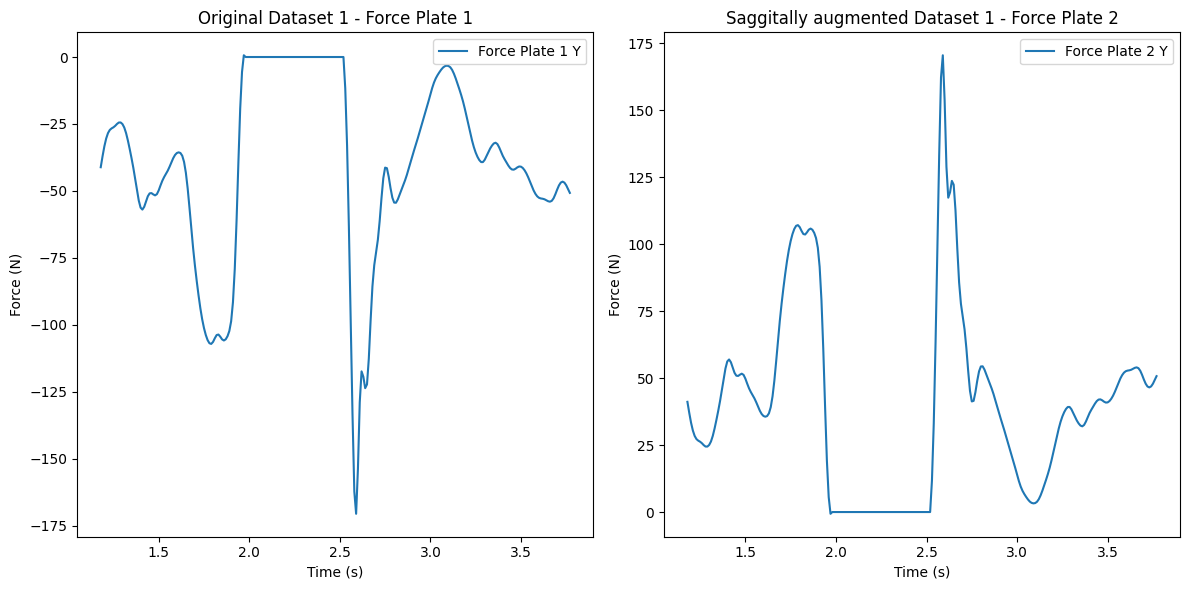

In [94]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(Dataframe_numpy['time'][0], Dataframe_numpy['force_plate_1_y'][0], label='Force Plate 1 Y')
plt.title("Original Dataset 1 - Force Plate 1")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(augmented_df_saggital['time'][0], augmented_df_saggital['force_plate_2_y'][0], label='Force Plate 2 Y')
plt.title("Saggitally augmented Dataset 1 - Force Plate 2")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.tight_layout()
plt.show()

#### 1.3.2. Augmentation with Averaging and Noise

It is possible to argue, that the average of two unhealthy people most likely creates data of a synthetic unheathly person as well. This is not true as a whole, but in many cases it is a reasonable way to enlarge the dataset for training purposes. How to do it is described here.
At first we start with the distribution of the classes. We plot a histogram for this.

<Axes: xlabel='status'>

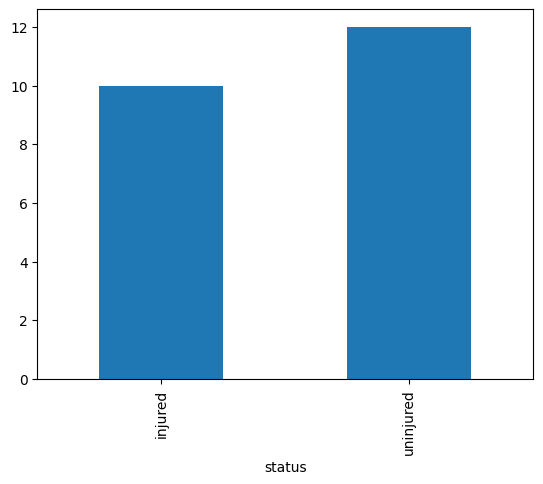

In [95]:
Dataframe.groupby('status').size().plot(kind='bar')

To create a weighted average of two or even more patients of a specific class it is necessary to split the data into healthy and unhealthy subsets

In [97]:
uninjured_df = Dataframe_numpy[Dataframe_numpy['status'] == 'uninjured']
injured_df = Dataframe_numpy[Dataframe_numpy['status'] == 'injured']

In a next step we need to augment data with averaging. To do so we create a function:

In [98]:
def create_average_rows(df):
  """Randomly picks two rows from the input DataFrame and creates the average of both.

  Args:
    df: The input DataFrame.

  Returns:
    A new DataFrame containing the average of two randomly selected rows.
  """

  # Randomly select two rows from the DataFrame
  row1 = df.sample()
  row2 = df.sample()

  # Iterate over the columns and compute the average of the values in row1 and row2
  average_row = {}
  for column in df.columns:
      if isinstance(row1[column].iloc[0], np.ndarray):
          # Handle NumPy arrays by averaging element-wise
          average_row[column] = (row1[column].iloc[0] + row2[column].iloc[0]) / 2
      else:
          # Handle other data types by simply averaging the values
          average_row[column] = row1[column].iloc[0]

  # Create a new DataFrame from the average_row dictionary
  new_df = pd.DataFrame([average_row])
  new_df.head()
  return new_df



Now we apply the function once to create a new augmented row by averaging. If you repeat to execute the cell below, the random pick is always a different one.

In [99]:
augmented_row=create_average_rows(injured_df)
augmented_row.head()

,time,force_plate_1_x,force_plate_1_y,force_plate_1_z,force_plate_2_x,force_plate_2_y,force_plate_2_z,status
0,"[1.085, 1.095, 1.105, 1.115, 1.125, 1.135, 1.1...","[-5.6082865, -7.300416500000001, -8.9794105, -...","[-64.86952600000001, -63.9329205, -62.590103, ...","[404.174103, 397.7058105, 390.4775545, 382.204...","[-6.8760045, -9.828119000000001, -12.579151, -...","[60.552080000000004, 61.467709, 62.24805449999...","[430.079559, 427.94198600000004, 423.0792695, ...",injured


As people tend to have a better idea about the outcome when it is shown in a visual way, we have a look at the augmented data.

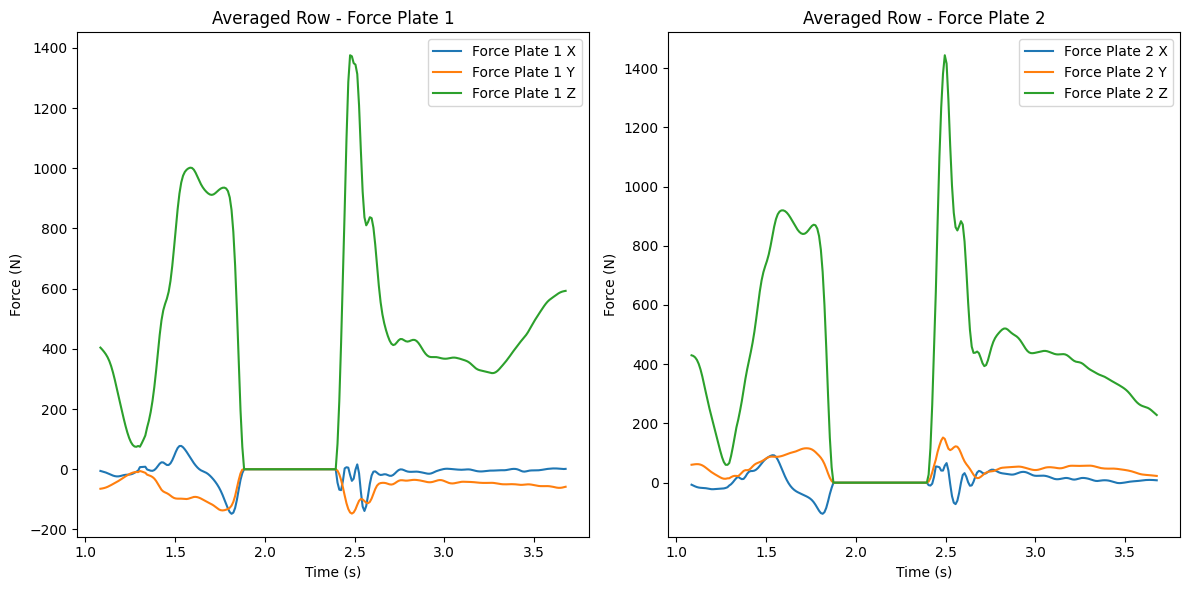

In [100]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(augmented_row['time'][0], augmented_row['force_plate_1_x'][0], label='Force Plate 1 X')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_1_y'][0], label='Force Plate 1 Y')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_1_z'][0], label='Force Plate 1 Z')
plt.title("Averaged Row - Force Plate 1")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(augmented_row['time'][0], augmented_row['force_plate_2_x'][0], label='Force Plate 2 X')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_2_y'][0], label='Force Plate 2 Y')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_2_z'][0], label='Force Plate 2 Z')
plt.title("Averaged Row - Force Plate 2")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.tight_layout()
plt.show()

As the augmentation method seems to work, we can now create an infinate amount of new samples, by tweaking the original function *create_average_rows()* slightly. Currently the function averages the two randomly chosen rows. To make the augmentation even more random, also the weight for each row can be created randomly.

#### TASK: Tweak *create_average_rows()* in a way, so it randomly weights the two chosen rows

In [101]:
def create_weighted_rows(df,weight):
  """Randomly picks two rows from the input DataFrame and multiplies a weight to both. E.g. x is the weight. row1 will be weighted with x, row2 will be weighted with (1-x).

  Args:
    df: The input DataFrame.
    weight: The weight of the first row.

  Returns:
    A new DataFrame containing the weighted multiplication of two randomly selected rows.
  """

  # your code goes here

  new_df = pd.DataFrame()

  return new_df

 Be aware, that you should be able to complete the task on your own.

If you need support, here is the solution to the TASK.

In [102]:
def create_weighted_rows(df,weight):
  """Randomly picks two rows from the input DataFrame and multiplies a weight to both. E.g. x is the weight. row1 will be weighted with x, row2 will be weighted with (1-x).

  Args:
    df: The input DataFrame.
    weight: The weight of the first row.

  Returns:
    A new DataFrame containing the weighted multiplication of two randomly selected rows.
  """

  # Randomly select two rows from the DataFrame
  row1 = df.sample()
  row2 = df.sample()

  # Iterate over the columns and compute the average of the values in row1 and row2
  average_row = {}
  for column in df.columns:
      if isinstance(row1[column].iloc[0], np.ndarray):
          # Handle NumPy arrays by averaging element-wise
          average_row[column] = row1[column].iloc[0]*weight + row2[column].iloc[0]*(1-weight)
      else:
          # Handle other data types by simply averaging the values
          average_row[column] = row1[column].iloc[0]

  # Create a new DataFrame from the average_row dictionary
  new_df = pd.DataFrame([average_row])

  return new_df

We set a seed number to be reproducable. Then we apply the funtion once an have a look at the output.

In [103]:
np.random.seed(42)
weight=np.random.uniform(0,1)
augmented_row=create_weighted_rows(unhealthy_df,weight)
augmented_row.head()

ValueError: a must be greater than 0 unless no samples are taken

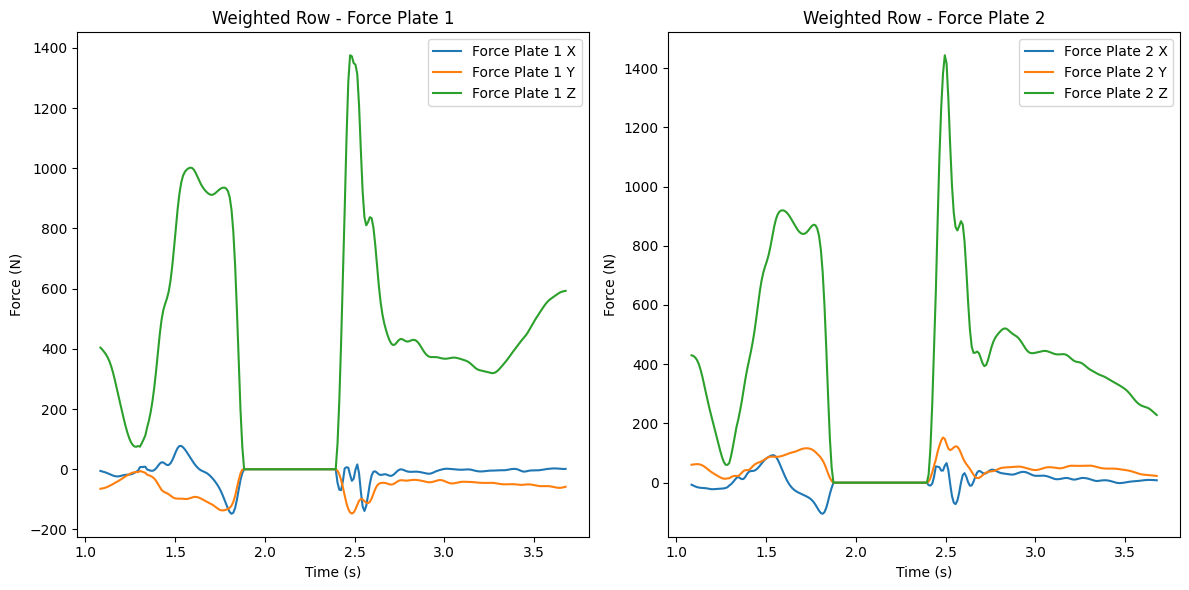

In [104]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(augmented_row['time'][0], augmented_row['force_plate_1_x'][0], label='Force Plate 1 X')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_1_y'][0], label='Force Plate 1 Y')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_1_z'][0], label='Force Plate 1 Z')
plt.title("Weighted Row - Force Plate 1")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(augmented_row['time'][0], augmented_row['force_plate_2_x'][0], label='Force Plate 2 X')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_2_y'][0], label='Force Plate 2 Y')
plt.plot(augmented_row['time'][0], augmented_row['force_plate_2_z'][0], label='Force Plate 2 Z')
plt.title("Weighted Row - Force Plate 2")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.tight_layout()
plt.show()

Now we can finally apply the function in a way to create a specific number of augmented weighted data for a specific class. Below we do this for unhealthy patients.

In [106]:
np.random.seed(42)
augmented_weighted_data = pd.DataFrame()
number_of_new_samples = 30

for i in range(number_of_new_samples):
  weight=np.random.uniform(0,1)
  augmented_row_injured=create_weighted_rows(injured_df,weight)
  augmented_row_unijured=create_weighted_rows(uninjured_df,weight)
  augmented_weighted_data=pd.concat([augmented_weighted_data,augmented_row_injured])
  augmented_weighted_data=pd.concat([augmented_weighted_data,augmented_row_unijured])

Adding noise is surely the easiest way to augment data. Sometimes it is reasonable, sometimes it is not. It highly depends on the specific case. In this case we do not add any noise to the signals, as it is not a challange to do so.


#### 1.3.3. Other Augmentation Methods

Other augmentations with time series can be found under
[tsai](https://timeseriesai.github.io/tsai/), [tsaug](https://tsaug.readthedocs.io/en/stable/) and [tsgm](https://tsgm.readthedocs.io/en/latest/guides/introduction.html)

## 1.4 Dataset Review

As we have made some augmentations, a new dataset can be introduced including the augmented data. Doing so means, we need to append the augmented datasets to the original one.

In [107]:
print("Dataframe_numpy has the shape: "+str(Dataframe_numpy.shape))
print("augmented_df_saggital has the shape: "+str(augmented_df_saggital.shape))
print("augmented_weighted_data.shape has the shape: "+str(augmented_weighted_data.shape))


Dataframe_numpy has the shape: (22, 8)
augmented_df_saggital has the shape: (22, 8)
augmented_weighted_data.shape has the shape: (60, 8)


We started with the following distribution

<Axes: xlabel='status'>

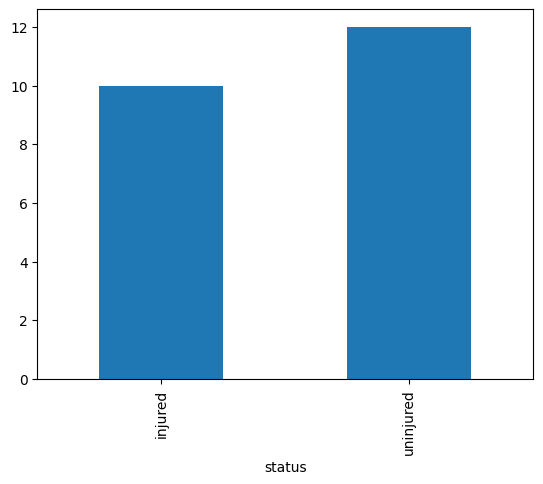

In [108]:
Dataframe.groupby('status').size().plot(kind='bar')

With augmentation we came to the following one.

<Axes: xlabel='status'>

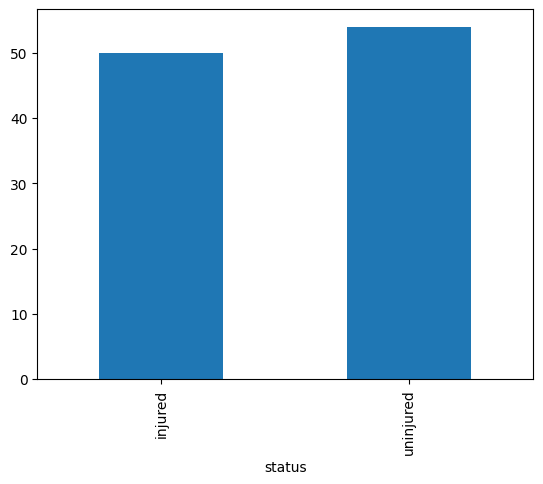

In [109]:
Dataset_incl_augmented_data=pd.concat([Dataframe_numpy,augmented_df_saggital,augmented_weighted_data])
Dataset_incl_augmented_data.groupby('status').size().plot(kind='bar')